In [868]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from scipy.stats.mstats import winsorize
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import normalize
from scipy.stats import bartlett
from scipy.stats import levene
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.stattools import acf
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sqlalchemy import create_engine


import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'


engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houses_prices = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

# Data Cleaning and Exploration

In [869]:
houses_prices.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


The data frame has 81 columns. It is very hard to have information about all these columns from the above table.

In [870]:
houses_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

The data frame has 1,459 rows. Almost half of the columns are "Strings" (43 Columns), 35 columns are "Integers", and only 2 columns are "Float". These columns are "garageyrblt", "masvnrarea", and "lotfrontage".

## Missing Values

In [871]:
total_missing = houses_prices.isnull().sum().sort_values(ascending=False)
percent_missing = (houses_prices.isnull().sum()/houses_prices.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(19)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


These are the missing values per column. Some of them has few missing values while the others have a very high percentage of missing values.

Let’s check them one by one:

Most of the missing values are representing a category (N/A) since these features are nominal categorical variables. These values are not missed by mistake, but it should represent a category (N/A). For example, feature "alley" is categorical variable representing the type of alley access to the house. it has 3 different values (paved, gravel, no alley access), the last one is the missing values. For these missing values, the string "N/A" will be filled.

Other features are missing because it should not have a value due to non-availability. This condition matches 2 features ("garageyrblt", and "masvnrarea"). These values are missing because these houses have no garage to have a value for the garage year built, and no masonry veneer to have an area for it. For "masvnrarea" feature a value of "zero" will be filled instead of a missing value, while for "garageyrblt", it is not possible to fill the missing values with “zero” because there is no year “zero”. This feature will not be considered to build the model because it has problems and it less likely contribute to the sale price of the house.

The last 2 features ("lotfrontage" and "electrical"), these features missing values where missed by mistake. it makes no sense to have a house with no lot frontage, and no house can be without an electrical system. For the "electrical" feature, the row with missing value will be dropped since it represents less than 0.1% of the data. For the "lotfrontage" feature, it will be filled with the mean lot frontage of the houses based on its neighborhoods lot frontages.

**First**, The below features missing values are replaced with a string (N/A) representing an additional category. All these features are Nominal Categorical Variables.

In [872]:
missing_values1 = ['poolqc', 'miscfeature', 'alley', 'fence', 'fireplacequ', 'garagecond', 'garagetype', 'garagefinish',
                  'garagequal', 'bsmtexposure', 'bsmtfintype2', 'bsmtfintype1', 'bsmtcond', 'bsmtqual', 'masvnrtype']

for i in range(0, len(missing_values1)):
    houses_prices[missing_values1[i]].fillna('N/A', inplace = True)

**Second**, The missing values of feature 'masvnrarea' is replaced by "zero", and the feature 'garageyrblt' will not be considered in this model.

In [710]:
houses_prices['masvnrarea'].fillna(0, inplace = True)

**Finally**, The only row with a missing 'electrical' value is dropped from the dataframe, and the missing values for 'lotfrontage' is replaced with the mean lotfrontage of the houses neighborhood.

In [885]:
houses_prices = houses_prices.dropna(axis = 0, subset = ['electrical'])

neighborhoods = houses_prices['neighborhood'].unique()

for neighborhood in neighborhoods:
    houses_prices.loc[houses_prices['neighborhood'] == neighborhood, 'lotfrontage'] = \
                                    houses_prices.loc[houses_prices['neighborhood'] == neighborhood, 'lotfrontage'].mean()

## Outliers

Two data frames will be created. One includes all "Non-Numeric" columns, while the other one will include the "Numeric" columns.

In [874]:
non_numeric_columns = houses_prices.select_dtypes(['object']).columns
numeric_columns = houses_prices.select_dtypes(['int64', 'float64']).columns

### Box Plot

All numeric columns are plotted using box plot to detect any outliers.

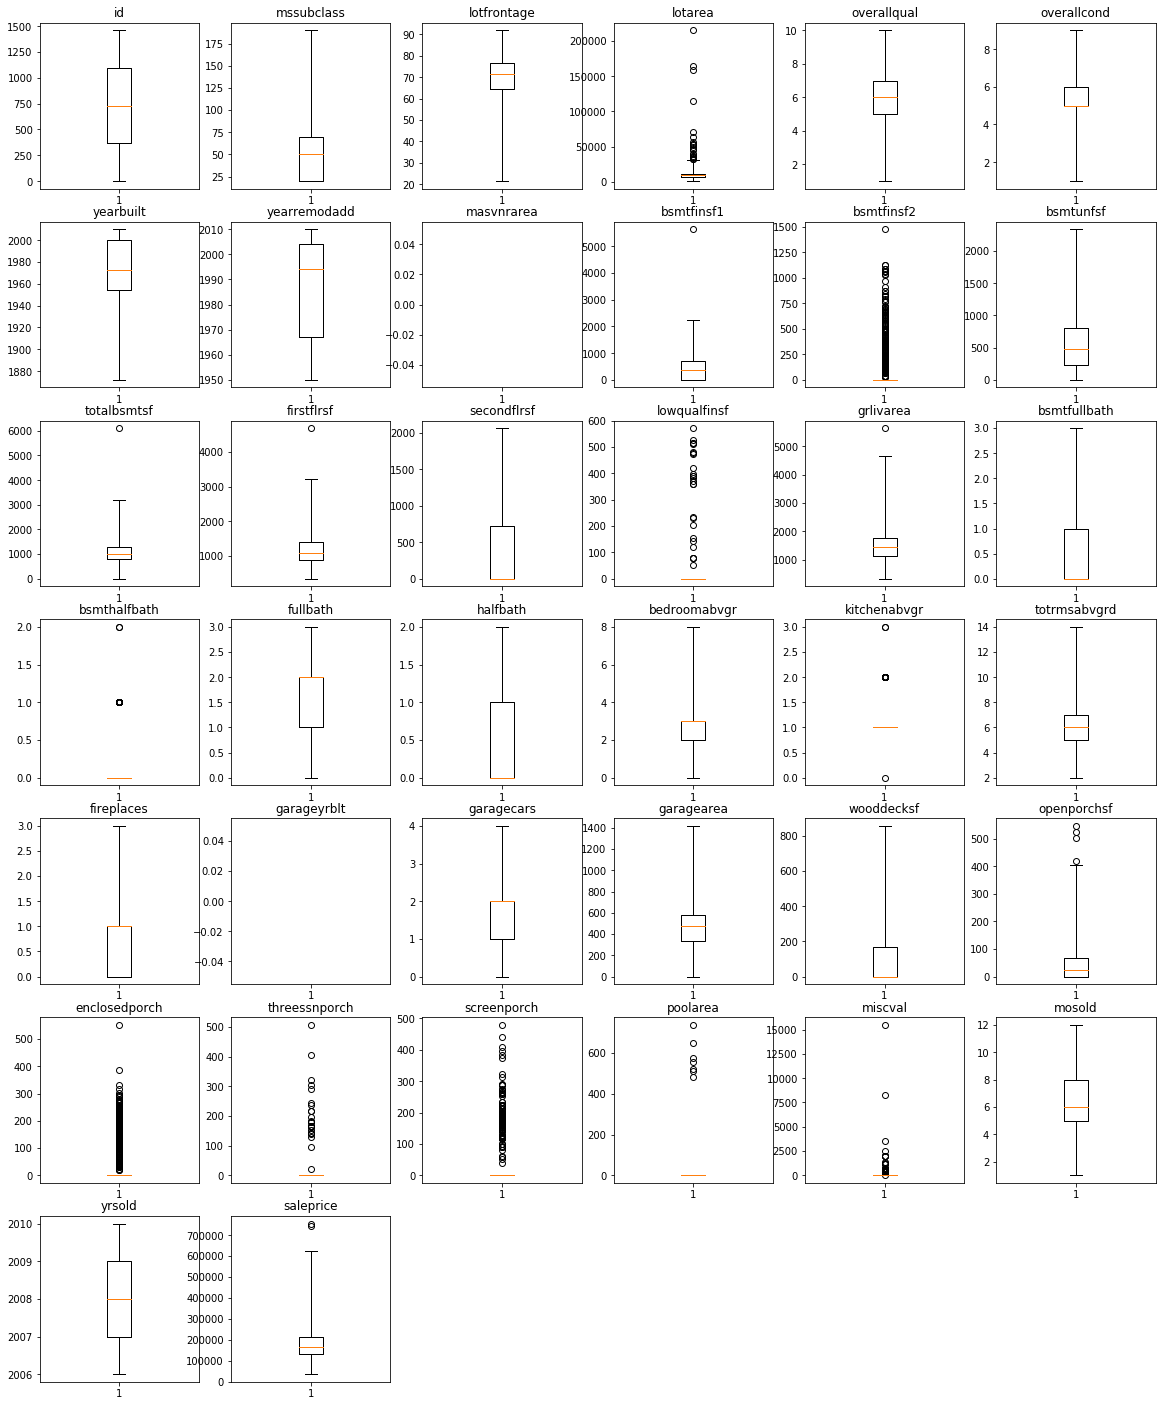

In [875]:
plt.figure(figsize = (20,25))
for i in range(0, len(numeric_columns)):
    plt.subplot(7,6,i+1)
    plt.boxplot(houses_prices[numeric_columns[i]], whis = 5)
    plt.title(numeric_columns[i])

16 features out of 37 features have at least 1 outlier including the target variable "saleprice". These features are divided into 3 groups:

**First group**, includes ('lotarea', 'masvnrarea', 'lowqualfinsf', 'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'miscval, 'saleprice). These features are potential significant features, they are continuous variables, they will be winsorized in the next stage.

**Second group**, includes ('totalbsmtsf', 'firstflrsf', 'grlivarea'). These features are potential significant features as well, but they have only one outlier. It could be related to only 1 entry. This could be a very big house compare to all other houses analyzed in this study. There are two options, deleting the outlier or winsorizing it. The winsorizing option has been chosen in this case.

**Third group**, includes ('bsmthalfbath', 'kitchenabvgr'). Even though, these features are numeric, but they are categorical. The first feature can have only these values (0, 1, 2) and the second feature can have (0,1,2,3). These features will be considered as categorical variables in this analysis and will be included with categorical data part of the analysis.

**Forth group**, includes ('bsmtfinsf1', 'bsmtfinsf2'). These features are related to other categorical variables in the analysis. it is unlikely to be useful in this model. For example, ‘bsmtfinsf1' means type 1 finished square feet which is related to another variable 'bsmtfintype1' which is categorical variable with 6 categorical variables ranging depending on the quality of the finish. The categorical variable might be useful in this analysis, but it is unlikely the continuous variables will be. These features will not be considered in this model.

### Winsorization

In [876]:
outlier_features = ['lotarea', 'masvnrarea', 'totalbsmtsf', 'firstflrsf', 'lowqualfinsf', 'grlivarea', 'openporchsf', 
                    'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'miscval', 'saleprice']
for feature in outlier_features:
    houses_prices[feature + "_win"] = winsorize(houses_prices[feature], (0.10, 0.10))

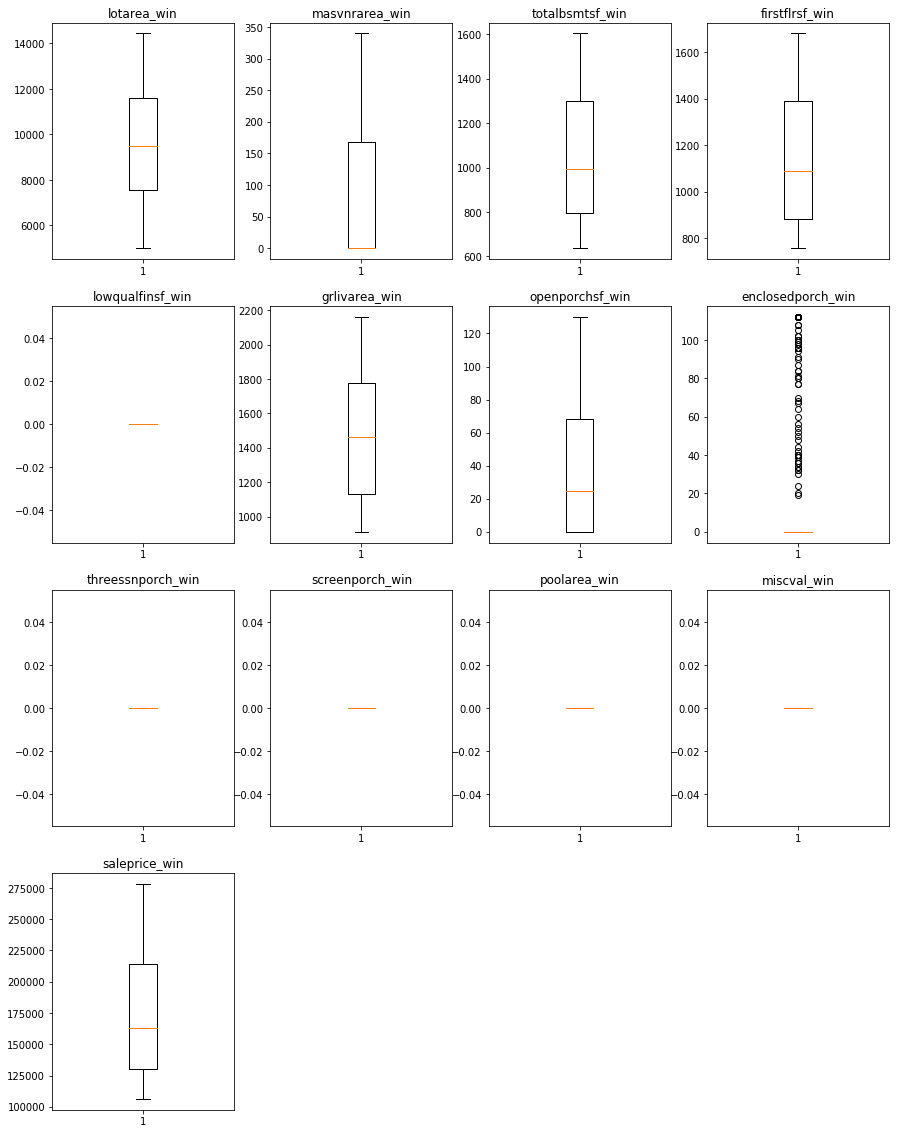

In [877]:
winsorized_features = ['lotarea_win', 'masvnrarea_win', 'totalbsmtsf_win', 'firstflrsf_win', 'lowqualfinsf_win', 
                       'grlivarea_win', 'openporchsf_win', 'enclosedporch_win', 'threessnporch_win', 'screenporch_win', 
                       'poolarea_win', 'miscval_win', 'saleprice_win']

plt.figure(figsize = (15,20))
for i in range(0, len(winsorized_features)):
    plt.subplot(4,4,i+1)
    plt.boxplot(houses_prices[winsorized_features[i]], whis = 5)
    plt.title(winsorized_features[i])

Winsorizing managed to deal with 7 features outliers while it did not work well with the remaining 6 features. All the values of these features now equal to "zero" except "enclosedporch_win" which still has outliers and winsorizing did now work with it.

Most properly, these features have a lot of “zero” values and winsorizing changed all these outliers’ values to be equal to zero and this is not helpful for the analysis. In the next step, these features will be normalized.

### Normalization

In [878]:
outlier_features_updated = ['lowqualfinsf', 'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'miscval']
for feature in outlier_features_updated:
    houses_prices[feature + "_norm"] = normalize(np.array(houses_prices[feature]).reshape(1,-1)).reshape(-1,1)

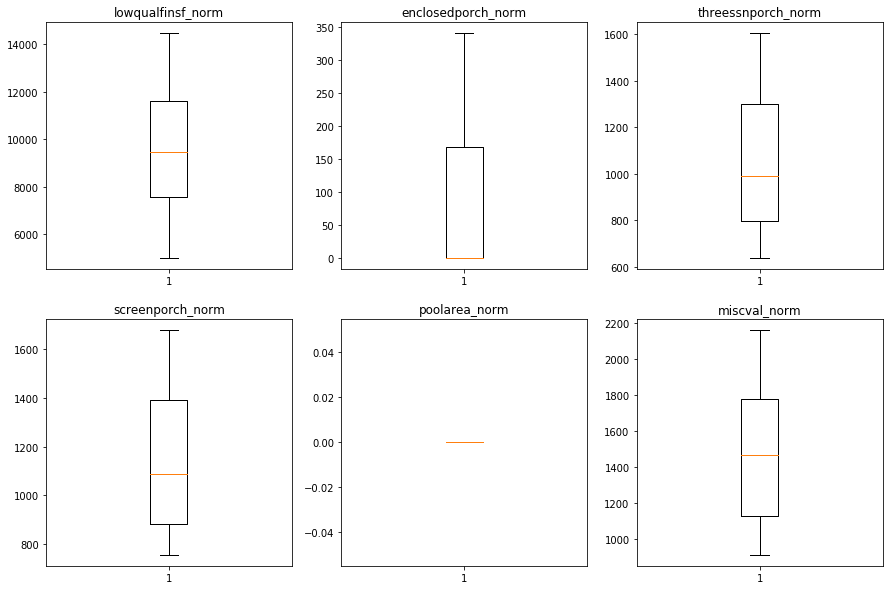

In [879]:
normalized_features = ['lowqualfinsf_norm', 'enclosedporch_norm', 'threessnporch_norm', 'screenporch_norm', 'poolarea_norm', 
                       'miscval_norm']

plt.figure(figsize = (15,10))
for i in range(0, len(normalized_features)):
    plt.subplot(2,3,i+1)
    plt.boxplot(houses_prices[winsorized_features[i]], whis = 5)
    plt.title(normalized_features[i])

Normalization worked well with all the features, and outliers are not detected after normalization. The only exception is "poolarea" where all values equalized to "zero" after normalization. This feature will be explored more to detect the reason behind this issue.

In [886]:
houses_prices[['poolarea']].describe()

,poolarea
count,1459.000000
mean,2.760795
std,40.191018
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,738.000000


In [881]:
len(houses_prices.loc[(houses_prices['poolarea'] != 0)])

7

In [882]:
percent_pool = len(houses_prices.loc[(houses_prices['poolarea'] != 0)]) * 100 / len(houses_prices.loc[(houses_prices['poolarea'] == 0)])
print ('percentage of houses have pool is {} % of the total houses in the study'.format(percent_pool))

percentage of houses have pool is 0.4820936639118457 % of the total houses in the study


After exploring this feature values, this feature will not be considered in this model, because only 7 houses (less than 0.5% of the houses) in this study have a pool. It is not going to be a useful feature.

## Data Visualization

In [883]:
numeric_features = ['saleprice_win', 'lotfrontage', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'bsmtunfsf', 'secondflrsf', 
                   'garagearea', 'wooddecksf', 'mosold', 'yrsold', 'lotarea_win', 'masvnrarea_win', 'totalbsmtsf_win', 
                    'firstflrsf_win', 'grlivarea_win', 'lowqualfinsf_norm', 'enclosedporch_norm', 'threessnporch_norm', 
                    'screenporch_norm', 'miscval_norm', 'totrmsabvgrd']

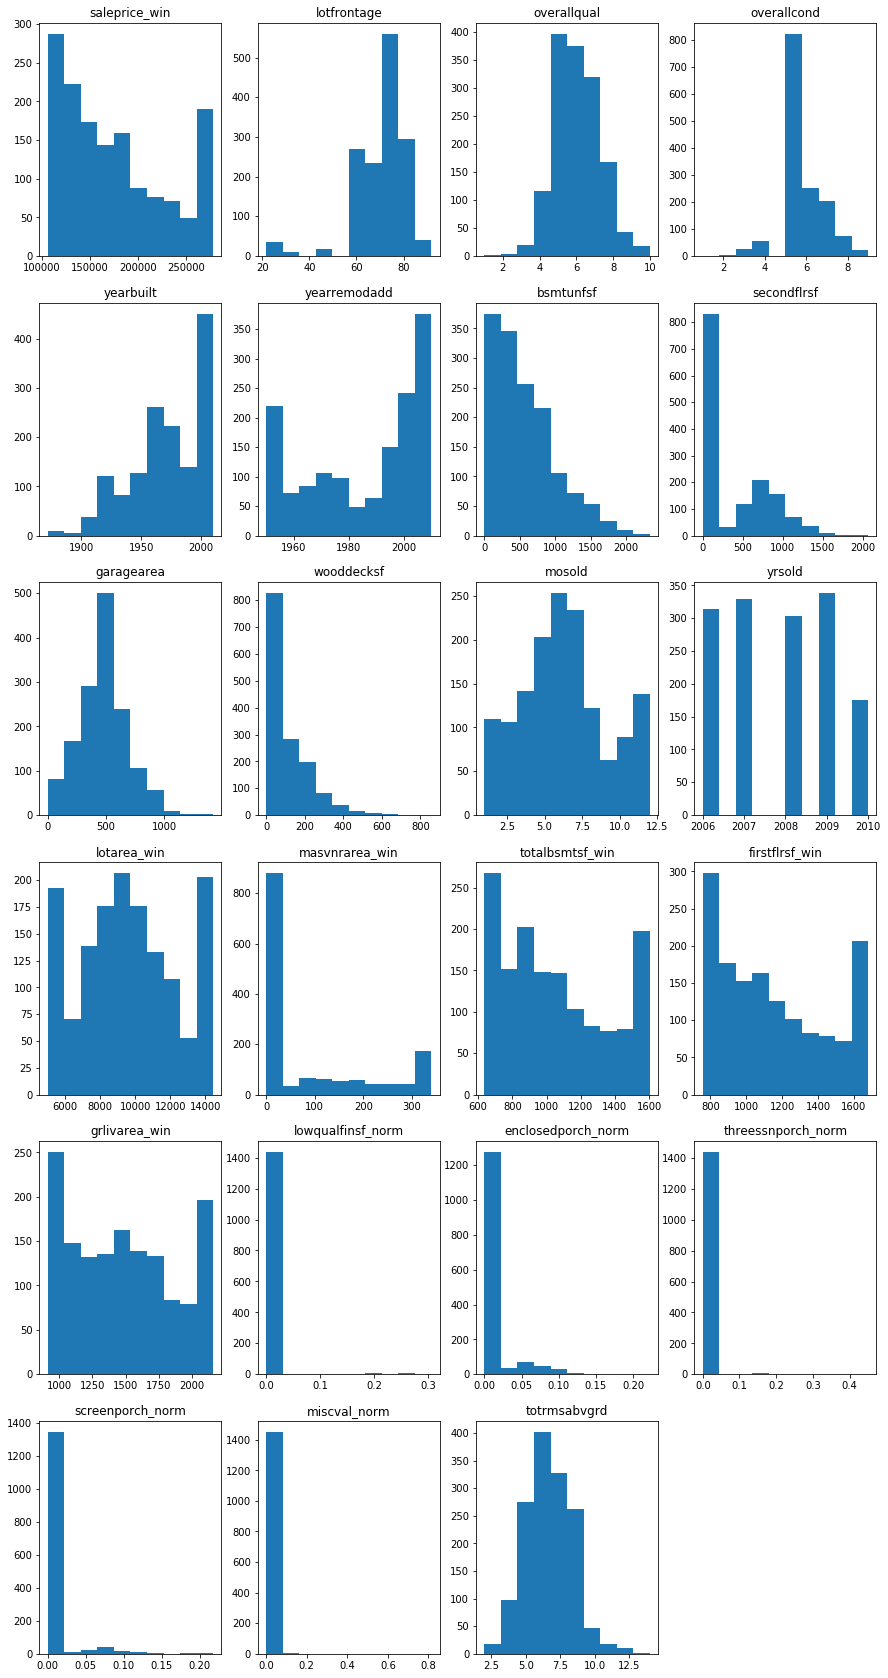

In [884]:
plt.figure(figsize = (15,30))
for index, column in enumerate(numeric_features):
    plt.subplot(6,4,index+1)
    plt.hist(houses_prices[numeric_features[index]])
    plt.title(numeric_features[index])
plt.show()

There is a high skewnes of some features data distribution. We will deal with this after selecting the features for the model. a correlation between the features and the target variable 'saleprice_win' will be used. Features with correlation higher than 0.5 will be preliminary selected for the model. 

In [887]:
np.abs(houses_prices[numeric_features].iloc[:,0:].corr().loc[:,"saleprice_win"]).sort_values(ascending=False)

saleprice_win         1.000000
overallqual           0.803515
grlivarea_win         0.726284
garagearea            0.637390
totalbsmtsf_win       0.626453
firstflrsf_win        0.593661
yearbuilt             0.585557
yearremodadd          0.562822
totrmsabvgrd          0.514025
lotarea_win           0.454285
masvnrarea_win        0.433102
lotfrontage           0.365194
wooddecksf            0.328121
secondflrsf           0.322270
bsmtunfsf             0.237027
enclosedporch_norm    0.142594
screenporch_norm      0.114061
overallcond           0.098314
mosold                0.071504
threessnporch_norm    0.051030
lowqualfinsf_norm     0.046561
yrsold                0.029973
miscval_norm          0.014717
Name: saleprice_win, dtype: float64

In [888]:
selected_features =['overallqual', 'grlivarea_win', 'garagearea', 'totalbsmtsf_win', 'firstflrsf_win', 'yearbuilt', 
                    'yearremodadd', 'totrmsabvgrd']

8 features have been preliminary selected for the model. They have skewenes but it is not as high as the dropped features. The selected features are shown below in the list above

### Numeric Columns data Visualization

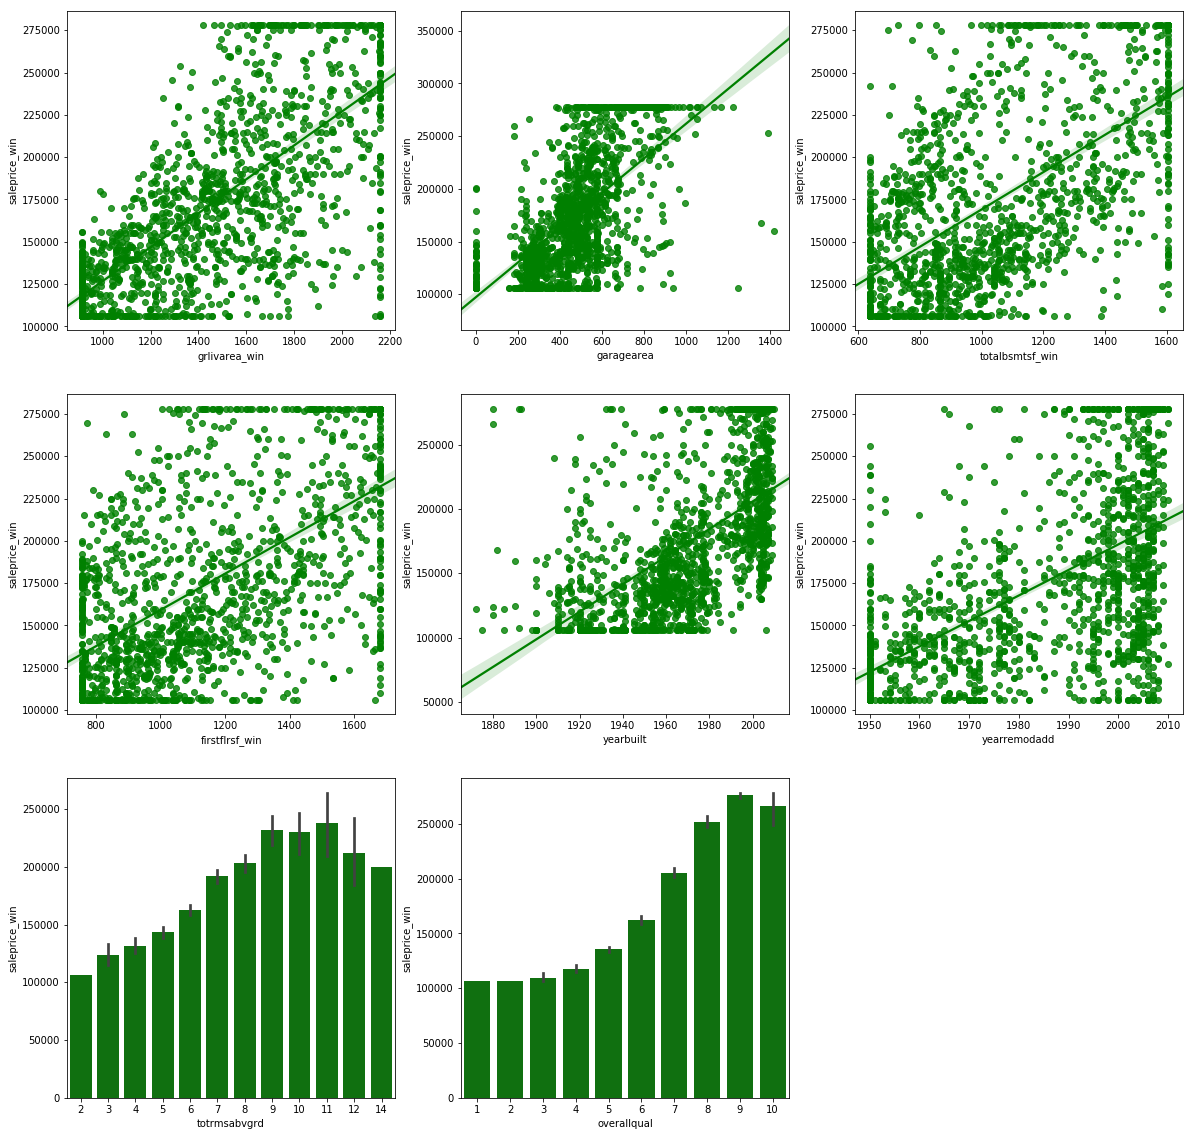

In [889]:
plt.figure(figsize=(20,20))

plt.subplot(3,3,1)
sns.regplot(houses_prices['grlivarea_win'], houses_prices['saleprice_win'], color = 'green')

plt.subplot(3,3,2)
sns.regplot(houses_prices['garagearea'], houses_prices['saleprice_win'], color = 'green')

plt.subplot(3,3,3)
sns.regplot(houses_prices['totalbsmtsf_win'], houses_prices['saleprice_win'], color = 'green')

plt.subplot(3,3,4)
sns.regplot(houses_prices['firstflrsf_win'], houses_prices['saleprice_win'], color = 'green')

plt.subplot(3,3,5)
sns.regplot(houses_prices['yearbuilt'], houses_prices['saleprice_win'], color = 'green')

plt.subplot(3,3,6)
sns.regplot(houses_prices['yearremodadd'], houses_prices['saleprice_win'], color = 'green')

plt.subplot(3,3,7)
sns.barplot(houses_prices['totrmsabvgrd'], houses_prices['saleprice_win'], color = 'green')

plt.subplot(3,3,8)
sns.barplot(houses_prices['overallqual'], houses_prices['saleprice_win'], color = 'green')

The above plots explore the relationship between each of the selected features and the target variable. Correlation is not very strong in most features. The highest correlation looks higher with 'overallqual' feature which can be considered as a categorical variable because it is based on Likert scale, but there will be no issue dealing with it as a continuous variable in this analysis.

There are clustering in the upper and lower limits of saleprice_win values due to winsorization.

Now, let’s select the features for the categorical variables. bar plots will be explored to choose the features which might have a strong relationship with the target variable.

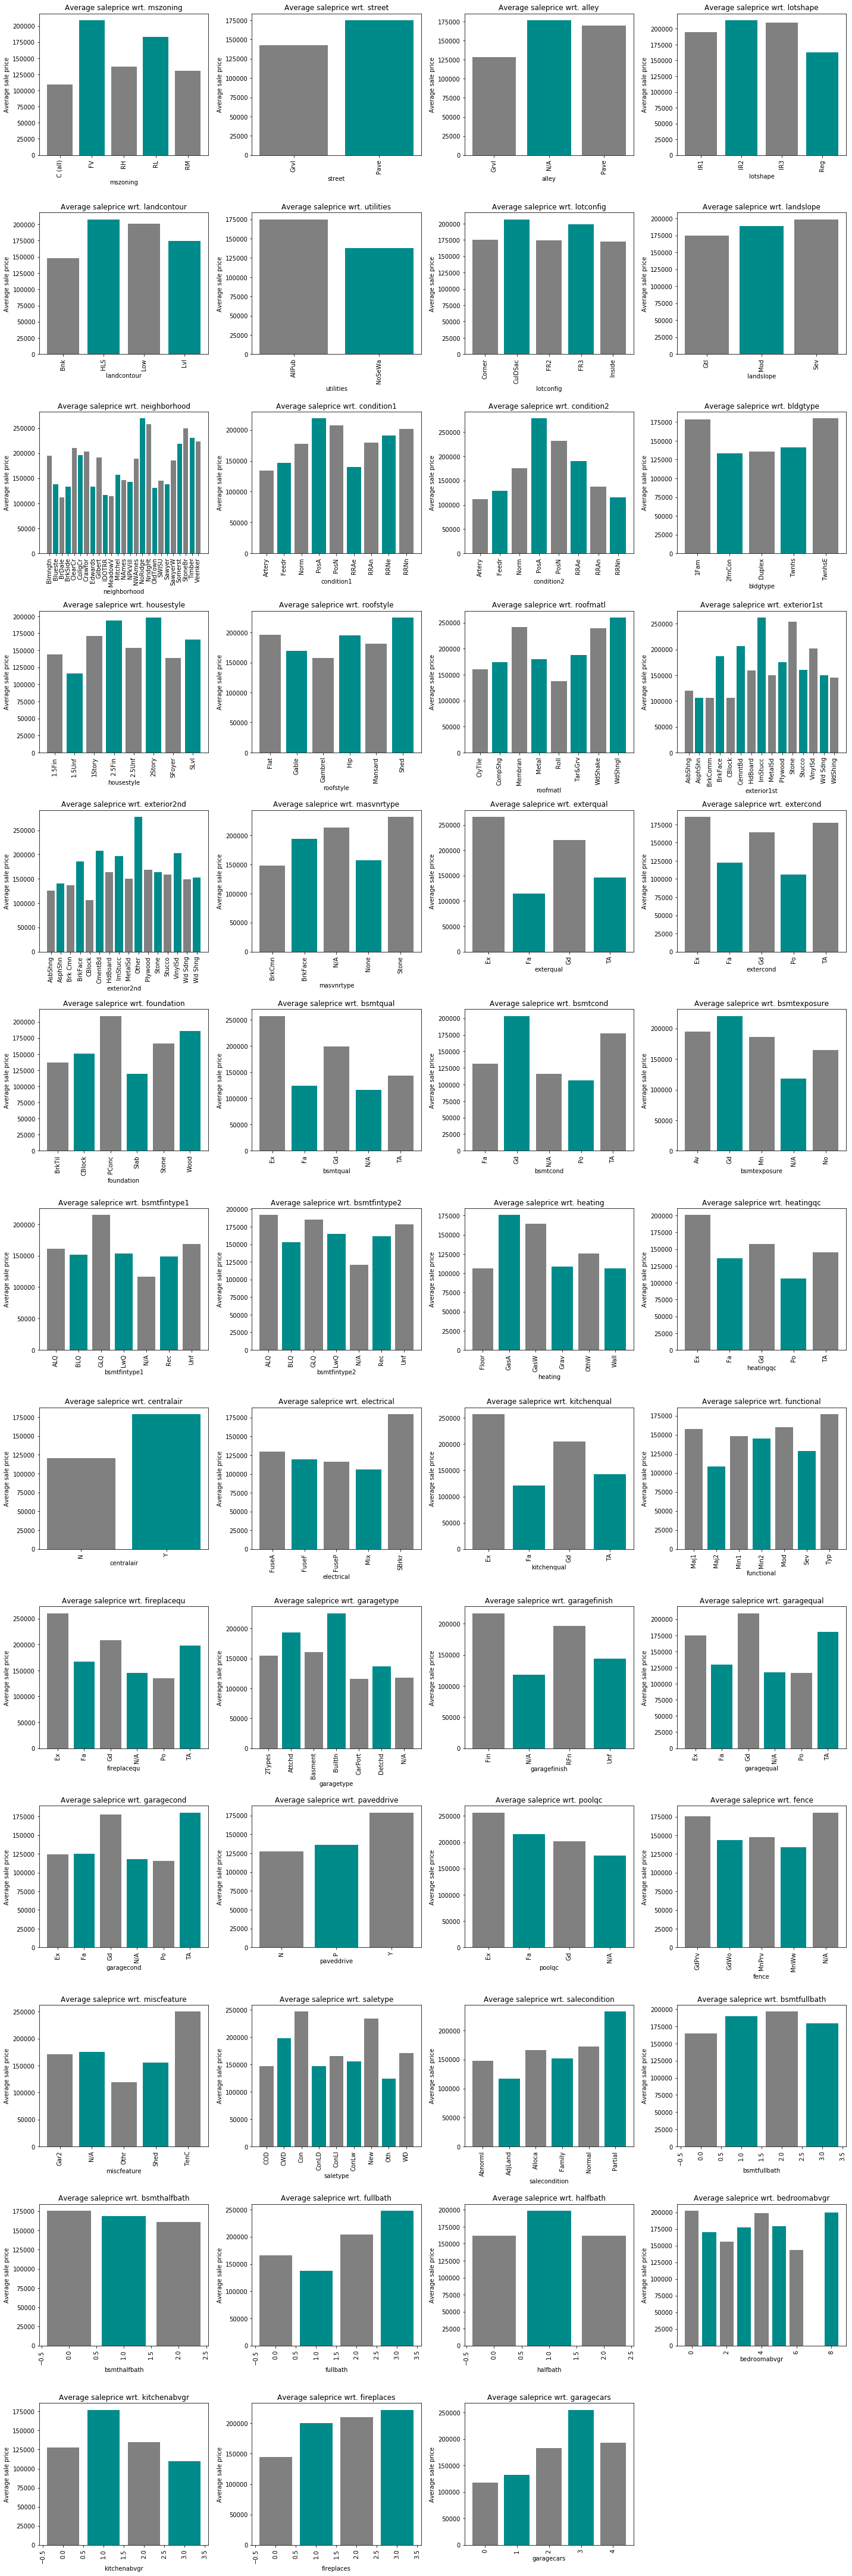

In [890]:
cat_features = ['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope', 
                'neighborhood', 'condition1', 'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 
                'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond', 
                'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc', 'centralair', 'electrical', 
                'kitchenqual', 'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal', 'garagecond', 
                'paveddrive', 'poolqc', 'fence', 'miscfeature', 'saletype', 'salecondition', 'bsmtfullbath', 'bsmthalfbath',
                'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'fireplaces', 'garagecars']

plt.figure(figsize=(20,60))

for index, column in enumerate(cat_features):
    plt.subplot(13,4,index+1)
    plt.bar(houses_prices.groupby(column)['saleprice_win'].mean().index, houses_prices.groupby(column)['saleprice_win'].mean(),
           color=('grey','darkcyan'))
    plt.title('Average saleprice wrt. {}'.format(column))
    plt.ylabel('Average sale price')
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

14 features have been preliminary selected shown below. The features will be explored to check for any imbalance.

In [892]:
pre_selected_cat_features = ['street', 'utilities', 'exterqual', "bsmtqual", "heatingqc", "centralair", "electrical", 
                            "kitchenqual", "fireplacequ", "garagefinish", "paveddrive", "garagecars", "fireplaces",
                            "fullbath"]

### Imbalance Detection

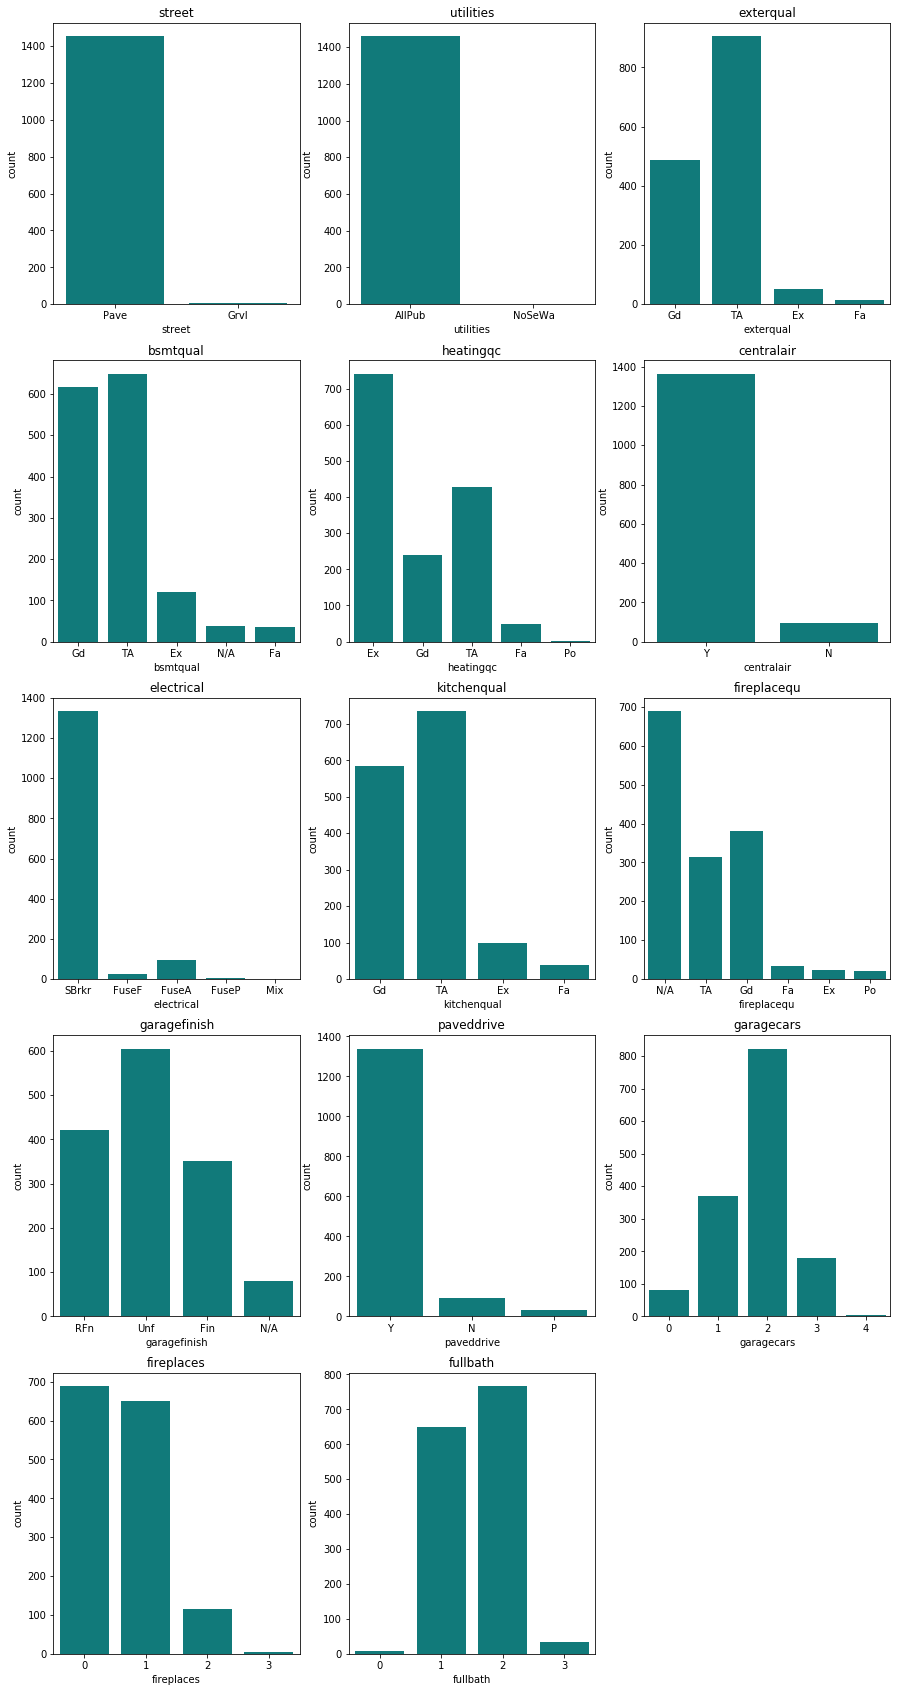

In [893]:
plt.figure(figsize=(15,30))
for index, column in enumerate(pre_selected_cat_features):
    plt.subplot(5,3,index+1)
    sns.countplot(x= prelim_selected_cat_features[index], data=houses_prices, color= "darkcyan")
    plt.title(prelim_selected_cat_features[index])
plt.show()

As it is shown above count plots, features ('street', 'utilities', 'centralair', 'electrical', 'paveddrive') are highly imbalanced. These features will not be included in the model.

Dummy columns will be created for each of the selected categorical features below:

In [894]:
selected_columns = ['exterqual', 'bsmtqual', 'heatingqc', 'kitchenqual', 'fireplacequ', 'garagefinish', 'fullbath']
dummy_column_names = []

for i in range(0, len(selected_columns)):
    houses_prices = pd.concat([houses_prices,pd.get_dummies(houses_prices[(selected_columns[i])], prefix=selected_columns[i], 
                                                            drop_first=True)], axis=1)
    dummy_column_names = dummy_column_names \
        + list(pd.get_dummies(houses_prices[(selected_columns[i])], prefix=selected_columns[i], drop_first=True).columns)

### Multicollinearity Check

The correlation will be checked between all the features considered for the model to detect multicollinearity. Any features with a correlation more than “0.5” or less than “- 0.5” will be considered highly correlated. For each pair of correlated features, the feature with higher correlation with the target variable "saleprice_win" will be kept while the other one will not be considered in the model.

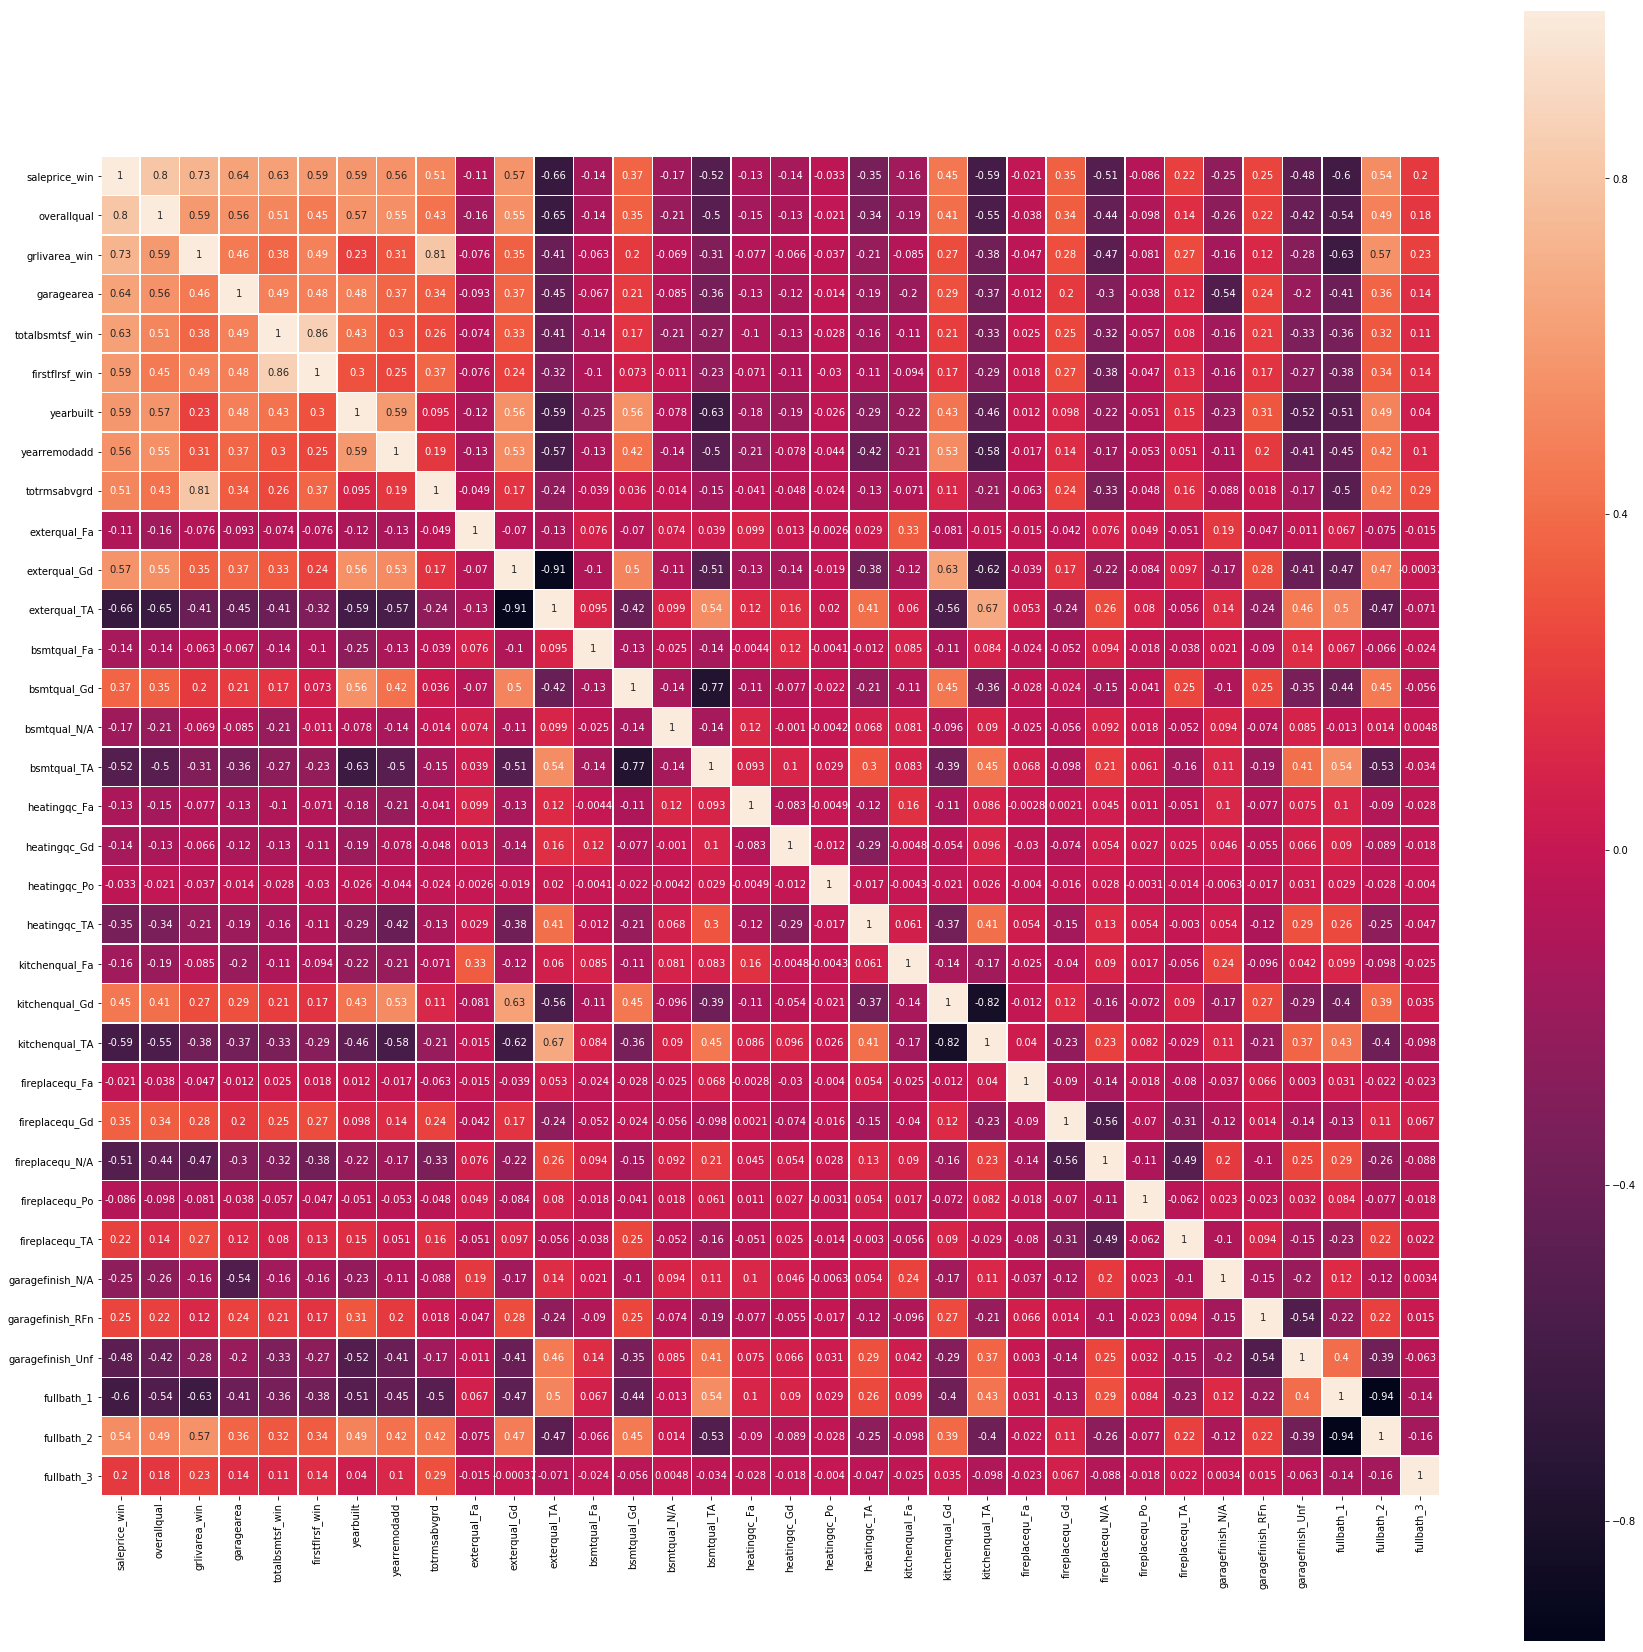

In [895]:
variables = ['saleprice_win'] + list(selected_features + dummy_column_names)
corrmat_houses = houses_prices[variables].corr()
plt.figure(figsize = (30,30))
sns.heatmap(corrmat_houses, square = True, annot = True, linewidths = 0.5)

Many features with high correlation between them and the feature "overallqual" will not be considered in the model. some dummy column has been dropped since most of the related dummy columns are correlated with each other and it will be meaningless to include them in the model. Finally, we have 12 features that will be used to build the model.

In [896]:
final_variables = ['overallqual', 'firstflrsf_win', 'totrmsabvgrd', 'heatingqc_Fa', 'heatingqc_Gd', 'heatingqc_Po', 
                     'heatingqc_TA', 'kitchenqual_Fa', 'kitchenqual_Gd', 'garagefinish_N/A', 'fullbath_2', 'fullbath_3']

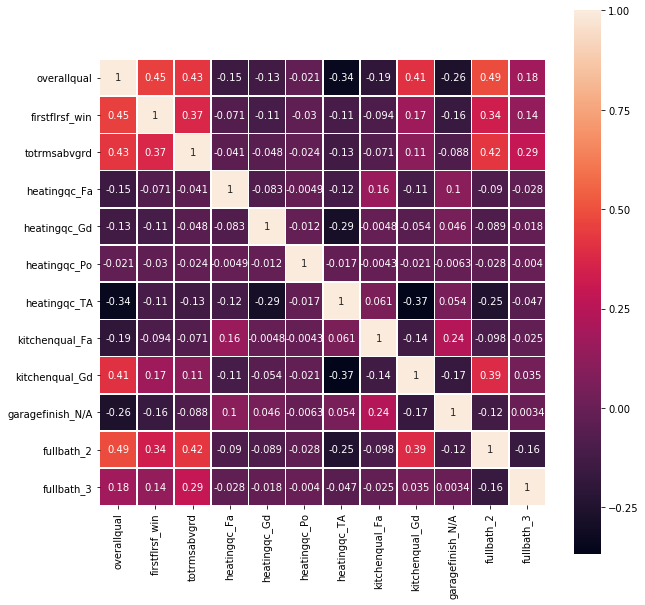

In [897]:
corrmat_houses2 = houses_prices[final_variables].corr()
plt.figure(figsize = (10,10))
sns.heatmap(corrmat_houses2, square = True, annot = True, linewidths = 0.5)

## Model #1

In [898]:
Y = houses_prices['saleprice_win']
X = houses_prices[final_variables]

Data is split into training and testing sets. 80% of the data will be used to train the data while the remaining 20% will be used to test the model.

In [899]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print('The number of observations in training set is {}'.format(X_train.shape[0]))
print('The number of observations in test set is {}'.format(X_test.shape[0]))

The number of observations in training set is 1167
The number of observations in test set is 292


In [900]:
X_train = sm.add_constant(X_train)

lrm1 = sm.OLS(y_train, X_train).fit()

lrm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          saleprice_win   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     365.0
Date:                Mon, 09 Sep 2019   Prob (F-statistic):               0.00
Time:                        14:00:28   Log-Likelihood:                -13521.
No. Observations:                1167   AIC:                         2.707e+04
Df Residuals:                    1155   BIC:                         2.713e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -3.724e+04   5502.520     -6.768      0.000    -4.8e+04   -2.64e+04
overallqual        2.06e+04    797.884     25.818      0.000     1.9e+04    2.22e+04
firstflrsf_win      43.0313      2.917     14.753      0.000      37.308      48.754
totrmsabvgrd      5135.0069    597.684      8.592      0.000    3962.338    6307.676
heatingqc_Fa     -4571.0152   4393.521     -1.040      0.298   -1.32e+04    4049.162
heatingqc_Gd     -9223.1460   2348.637     -3.927      0.000   -1.38e+04   -4615.074
heatingqc_Po      2.286e-12   1.18e-12      1.944      0.052   -2.18e-14    4.59e-12
heatingqc_TA     -1.113e+04   2079.628     -5.354      0.000   -1.52e+04   -7053.129
kitchenqual_Fa   -3481.4868   5108.208     -0.682      0.496   -1.35e+04    6540.920
kitchenqual_Gd    1.045e+04   1866.009      5.602      0.000    6792.465    1.41e+04
garagefinish_N/A -7447.7057   3700.460     -2.013      0.044   -1.47e+04    -187.328
fullbath_2        8621.2233   2069.646      4.166      0.000    4560.536    1.27e+04
fullbath_3        1.055e+04   5936.872      1.777      0.076   -1100.494    2.22e+04
==============================================================================
Omnibus:                       23.313   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.606
Skew:                          -0.030   Prob(JB):                     1.25e-10
Kurtosis:                       3.967   Cond. No.                     4.58e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.9e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

R-Square = 0.777 and adj. R-Square = 0.774. The R-Square value looks acceptable.

### Model Evaluation

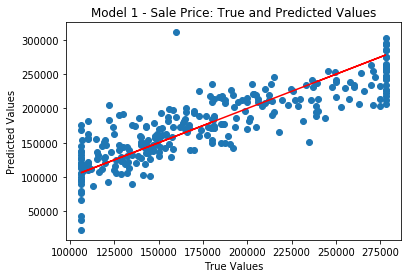

Mean absolute error of the prediction is: 22849.591281583467
Mean squared error of the prediction is: 908842343.8198396
Root mean squared error of the prediction is: 30147.012187277192
Mean absolute percentage error of the prediction is: 14.000013263693772


In [901]:
X_test = sm.add_constant(X_test)

y_preds = lrm1.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Model 1 - Sale Price: True and Predicted Values')
plt.show()

print('Mean absolute error of the prediction is: {}'.format(mean_absolute_error(y_test, y_preds)))
print('Mean squared error of the prediction is: {}'.format(mse(y_test, y_preds)))
print('Root mean squared error of the prediction is: {}'.format(rmse(y_test, y_preds)))
print('Mean absolute percentage error of the prediction is: {}'.format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

In general, the model performing well in predicting the houses prices values. The model is slightly under predicting the houses prices when the values of the houses are more expensive.

### Cross Validation

In [902]:
print(cross_val_score(LinearRegression(), X, Y, scoring='r2', cv = 5))
print(cross_val_score(LinearRegression(), X, Y, scoring='r2', cv = 5).mean())

[0.76396095 0.76653789 0.79165493 0.74983366 0.72820526]
0.7600385383532613


The model looks good. No overfitting and the R-Square does not vary much between the groups.

## Model #2

In this model, features with a p-value < 0.05 in the previous model will be kept while the remaining will be dropped from the model including related dummy features. The dropped features are all “heatingqc”,  “kitchenqual”, and “fullbath” dummy features.

In [903]:
sig_features = ['overallqual', 'firstflrsf_win', 'totrmsabvgrd', 'garagefinish_N/A']

In [904]:
Y2 = houses_prices['saleprice_win']
X2 = houses_prices[sig_features]

In [905]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, Y2, test_size = 0.2, random_state = 465)

print('The number of observations in training set is {}'.format(X2_train.shape[0]))
print('The number of observations in test set is {}'.format(X2_test.shape[0]))

The number of observations in training set is 1167
The number of observations in test set is 292


In [906]:
X2_train = sm.add_constant(X2_train)

lrm2 = sm.OLS(y2_train, X2_train).fit()
lrm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          saleprice_win   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     873.6
Date:                Mon, 09 Sep 2019   Prob (F-statistic):               0.00
Time:                        14:04:57   Log-Likelihood:                -13585.
No. Observations:                1167   AIC:                         2.718e+04
Df Residuals:                    1162   BIC:                         2.721e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -6.618e+04   4448.374    -14.877      0.000   -7.49e+04   -5.74e+04
overallqual       2.524e+04    712.158     35.444      0.000    2.38e+04    2.66e+04
firstflrsf_win      44.4367      3.044     14.601      0.000      38.465      50.408
totrmsabvgrd      5601.8676    569.043      9.844      0.000    4485.400    6718.335
garagefinish_N/A -7660.8417   3762.119     -2.036      0.042    -1.5e+04    -279.535
==============================================================================
Omnibus:                       25.289   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.713
Skew:                          -0.003   Prob(JB):                     5.90e-12
Kurtosis:                       4.031   Cond. No.                     6.93e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-Square = 0.750 and adj. R-Square = 0.750. The value of R-Square went slightly down compare to the first model. This is because of no major changes on the model except removing the features with no significant coefficients (p-value > 0.05), and these features effect on the previous model were close to ”zero”.

### Model Evaluation

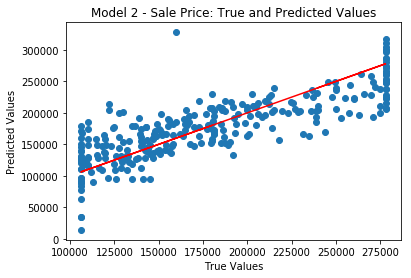

Mean absolute error of the prediction is: 25486.458648946733
Mean squared error of the prediction is: 1093178475.6396298
Root mean squared error of the prediction is: 33063.24962310314
Mean absolute percentage error of the prediction is: 15.819868635033856


In [907]:
X2_test = sm.add_constant(X2_test)

y2_preds = lrm2.predict(X2_test)

plt.scatter(y2_test, y2_preds)
plt.plot(y2_test, y2_test, color='red')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Model 2 - Sale Price: True and Predicted Values')
plt.show()

print('Mean absolute error of the prediction is: {}'.format(mean_absolute_error(y2_test, y2_preds)))
print('Mean squared error of the prediction is: {}'.format(mse(y2_test, y2_preds)))
print('Root mean squared error of the prediction is: {}'.format(rmse(y2_test, y2_preds)))
print('Mean absolute percentage error of the prediction is: {}'.format(np.mean(np.abs((y2_test - y2_preds) / y2_test)) * 100))

This first model looks better than this model. The values of all evaluation metrics have increased, and prediction errors are higher.

### Cross Validation

In [908]:
print(cross_val_score(LinearRegression(), X2, Y2, scoring='r2', cv = 5))
print(cross_val_score(LinearRegression(), X2, Y2, scoring='r2', cv = 5).mean())

[0.7332828  0.72413807 0.75568292 0.72507482 0.70165288]
0.7279662975602166


This model looks slightly better the Model #1, the variation between R-Square values has slightly decreased.

## Model #3

In this model, new features will be added to Model #2 features., These features are the interaction between model features, and they are:

"totalsf”: It will be the interaction feature between 4 features representing the total square feet area of each house.
"int_over_sf”: This feature will be the interaction between the total square feet of the house, and it is overall quality. It is computed by multiplying "totalsf" and "overallqual" features.
"avg_heatingqc”: This is going to represent the houses with relatively good and average heating system quality, it will be calculated by summing "heatingqc_Gd" and "heatingqc_TA".
"low_heatingqc”: This is going to represent the houses with relatively poor heating system quality, it will be calculated by summing "heatingqc_Fa" and "heatingqc_Po".
Since these are dummy features, if the both new imteraction features equal "zero", them the heating quality of the house is "excelent" since "heatingqc_Ex" is the dropped feature when creating the dummy columns.

In [910]:
houses_prices['totalsf'] = houses_prices['garagearea'] + houses_prices['totalbsmtsf_win'] \
                         + houses_prices['firstflrsf_win'] + houses_prices['secondflrsf']

houses_prices['int_over_sf'] = houses_prices['totalsf'] * houses_prices['overallqual']

houses_prices['avg_heatingqc'] = houses_prices['heatingqc_Gd'] + houses_prices['heatingqc_TA']
houses_prices['low_heatingqc'] = houses_prices['heatingqc_Fa'] + houses_prices['heatingqc_Po']

In [911]:
updated_features = ['overallqual', 'firstflrsf_win', 'totrmsabvgrd', 'garagefinish_N/A', 'totalsf', 'int_over_sf', 
                    'avg_heatingqc', 'low_heatingqc']

Multicollinearity between the features is checked below:

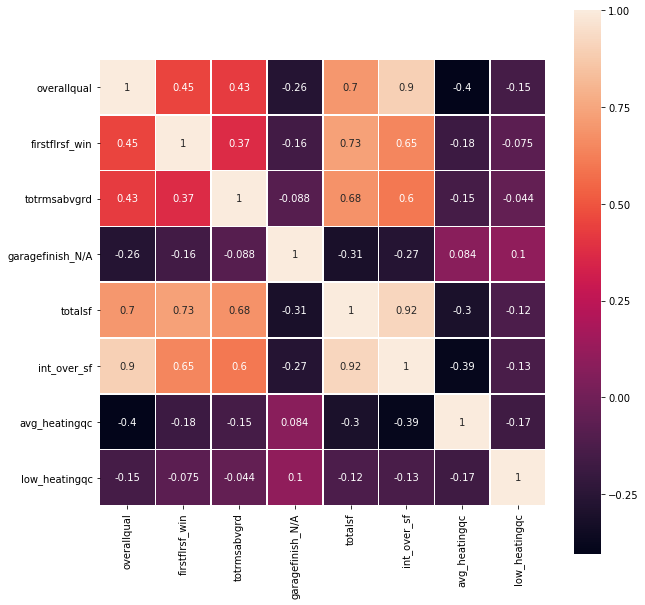

In [912]:
corrmat_houses3 = houses_prices[updated_features].corr()
plt.figure(figsize = (10,10))
sns.heatmap(corrmat_houses3, square = True, annot = True, linewidths = 0.5)

In [913]:
Y3 = houses_prices['saleprice_win']
X3 = houses_prices[updated_features]

In [914]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, Y3, test_size = 0.2, random_state = 465)

print('The number of observations in training set is {}'.format(X3_train.shape[0]))
print('The number of observations in test set is {}'.format(X3_test.shape[0]))

The number of observations in training set is 1167
The number of observations in test set is 292


In [915]:
X3_train = sm.add_constant(X3_train)

lrm3 = sm.OLS(y3_train, X3_train).fit()

lrm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          saleprice_win   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     660.3
Date:                Mon, 09 Sep 2019   Prob (F-statistic):               0.00
Time:                        14:23:08   Log-Likelihood:                -13394.
No. Observations:                1167   AIC:                         2.681e+04
Df Residuals:                    1158   BIC:                         2.685e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -5055.9303   1.23e+04     -0.411      0.681   -2.92e+04    1.91e+04
overallqual       1.213e+04   1999.078      6.067      0.000    8206.149    1.61e+04
firstflrsf_win       0.3261      3.478      0.094      0.925      -6.497       7.150
totrmsabvgrd     -1519.2907    625.776     -2.428      0.015   -2747.072    -291.509
garagefinish_N/A  6287.6225   3462.582      1.816      0.070    -506.014    1.31e+04
totalsf             31.3909      4.471      7.022      0.000      22.620      40.162
int_over_sf          1.3338      0.586      2.276      0.023       0.184       2.483
avg_heatingqc     -1.12e+04   1584.674     -7.068      0.000   -1.43e+04   -8091.328
low_heatingqc    -5476.5113   3896.441     -1.406      0.160   -1.31e+04    2168.363
==============================================================================
Omnibus:                      130.795   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              617.370
Skew:                          -0.411   Prob(JB):                    8.71e-135
Kurtosis:                       6.467   Cond. No.                     3.87e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.87e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-Square has increased to 0.82 which is better compare to Models #1 and #2. Adjusted R-Square is 0.819

### Model Evaluation

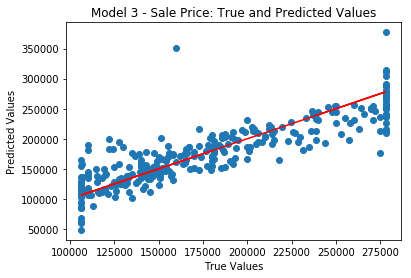

Mean absolute error of the prediction is: 19424.050784055158
Mean squared error of the prediction is: 784562780.8890345
Root mean squared error of the prediction is: 28010.04785588619
Mean absolute percentage error of the prediction is: 11.828994511003419


In [916]:
X3_test = sm.add_constant(X3_test)

y3_preds = lrm3.predict(X3_test)

plt.scatter(y3_test, y3_preds)
plt.plot(y3_test, y3_test, color='red')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Model 3 - Sale Price: True and Predicted Values')
plt.show()

print('Mean absolute error of the prediction is: {}'.format(mean_absolute_error(y3_test, y3_preds)))
print('Mean squared error of the prediction is: {}'.format(mse(y3_test, y3_preds)))
print('Root mean squared error of the prediction is: {}'.format(rmse(y3_test, y3_preds)))
print('Mean absolute percentage error of the prediction is: {}'.format(np.mean(np.abs((y3_test - y3_preds) / y3_test)) * 100))

This model is the best based on the evaluation metrics. All evaluation metrics has significantly decreased compare to previous models.

In [917]:
print(cross_val_score(LinearRegression(), X3, Y3, scoring='r2', cv = 5))
print(cross_val_score(LinearRegression(), X3, Y3, scoring='r2', cv = 5).mean())

[0.82648802 0.81754906 0.81401788 0.81409503 0.73567711]
0.8015654197784036


This model has more spread in R-Square values. one of the groups has a 0.74 R-Square value which is different than the rest of the groups which have a R-Square values close to the mean, but this does not mean we have overfitting in this model because the deviation is not high.

In conclusion, **Model #3** is the best model among the models despite the fact it scored the worst in terms of cross validation.

## Selected Model Assumptions Check

### Assumption 1: Linearity of the model in its coefficients

The target variable "saleprice_win" for the selected model "Model 3" is a linear function of model's coefficients, which mean that this assumption is met.

### Assumption 2: The error term should be zero on average

In [947]:
predictions = lrm3.predict(X3_train)
errors = y3_train - predictions

print('Mean of the errors in the houses prices model is: {}'.format(np.mean(errors)))

Mean of the errors in the houses prices model is: -6.91848177376627e-09


The mean of the errors in the model is very close to zero. Assumption has been met.

### Assumption 3: Homoscedasticity

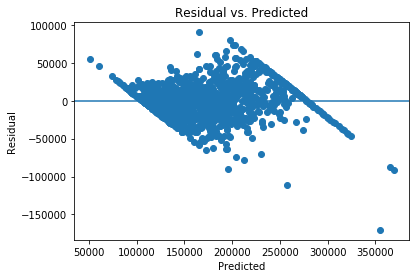

In [619]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [946]:
bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print('Bartlett test statistic value is {0:3g} and p value is {1:.3g}'.format(bart_stats[0], bart_stats[1]))
print('Levene test statistic value is {0:3g} and p value is {1:.3g}'.format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 615.176 and p value is 8.37e-136
Levene test statistic value is 520.173 and p value is 4.2e-104


Even though, errors look unbalanced at the extreme low and high prices of the houses, but the model passed the homoscedasticity test since the p-values of Bartlett test and Levene test are significantly lower than 0.05. Therefore, assumption has been met.

### Assumption 4: Low multicollinearity

This assumption has been checked earlier under Model#3 section. All features are not highly correlated with each other, and as a result no multicollinearity is there. Assumption has been met.

### Assumption 5: Error terms should be uncorrelated with one another

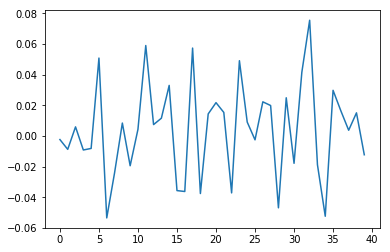

In [622]:
acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

By using autocorrelation function, the autocorrelation between the errors of the model is indeed very low (ranging between -0.05 and 0.07). This assumption has been met as well.

### Assumption 6: Features shouldn't be correlated with the errors

In [673]:
from scipy.stats.stats import pearsonr

for feature in updated_features:
    corr_test = pearsonr(X3_train[feature], lrm3.resid)
    print(f'Variable: {feature} --- correlation: {corr_test[0]:.4f}, p-value: {corr_test[1]:.4f}')

Variable: overallqual --- correlation: 0.0000, p-value: 1.0000
Variable: firstflrsf_win --- correlation: -0.0000, p-value: 1.0000
Variable: totrmsabvgrd --- correlation: 0.0000, p-value: 1.0000
Variable: garagefinish_N/A --- correlation: -0.0000, p-value: 1.0000
Variable: totalsf --- correlation: 0.0000, p-value: 1.0000
Variable: int_over_sf --- correlation: 0.0000, p-value: 1.0000
Variable: high_heatingqc --- correlation: -0.0000, p-value: 1.0000
Variable: low_heatingqc --- correlation: -0.0000, p-value: 1.0000


This assumption has been met since not correlation is shown above between the features and the errors.

## Ridge Model

In [387]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [945]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X3_train, y3_train)

y_preds_train = ridge_cv.predict(X3_train)
y_preds_test = ridge_cv.predict(X3_test)

print('Best alpha value is: {}'.format(ridge_cv.alpha_))
print('R-squared of the model in training set is: {}'.format(ridge_cv.score(X3_train, y3_train)))
print('-----Test set statistics-----')
print('R-squared of the model in test set is: {}'.format(ridge_cv.score(X3_test, y3_test)))
print('Mean absolute error of the prediction is: {}'.format(mean_absolute_error(y3_test, y_preds_test)))
print('Mean squared error of the prediction is: {}'.format(mse(y3_test, y_preds_test)))
print('Root mean squared error of the prediction is: {}'.format(rmse(y3_test, y_preds_test)))
print('Mean absolute percentage error of the prediction is: {}'.format(np.mean(np.abs((y3_test - y_preds_test) / y3_test)) * 100))

Best alpha value is: 10.0
R-squared of the model in training set is: 0.82012142326135
-----Test set statistics-----
R-squared of the model in test set is: 0.749671191982183
Mean absolute error of the prediction is: 19375.865502655528
Mean squared error of the prediction is: 786731413.4811224
Root mean squared error of the prediction is: 28048.7328320037
Mean absolute percentage error of the prediction is: 11.783231572653662


In [691]:
print(cross_val_score(ridge_cv, X3, Y3, scoring='r2', cv = 5))
print(cross_val_score(ridge_cv, X3, Y3, scoring='r2', cv = 5).mean())

[0.82677031 0.81733463 0.81394105 0.81422199 0.73571636]
0.8015968681514076


No major difference compare to select model "Model #3"

## Lasso Model

In [942]:
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X3_train, y3_train)

# We are making predictions here
y2_preds_train = lasso_cv.predict(X3_train)
y2_preds_test = lasso_cv.predict(X3_test)

print('Best alpha value is: {}'.format(lasso_cv.alpha_))
print('R-squared of the model in training set is: {}'.format(lasso_cv.score(X3_train, y3_train)))
print('-----Test set statistics-----')
print('R-squared of the model in test set is: {}'.format(lasso_cv.score(X3_test, y3_test)))
print('Mean absolute error of the prediction is: {}'.format(mean_absolute_error(y3_test, y2_preds_test)))
print('Mean squared error of the prediction is: {}'.format(mse(y3_test, y2_preds_test)))
print('Root mean squared error of the prediction is: {}'.format(rmse(y3_test, y2_preds_test)))
print('Mean absolute percentage error of the prediction is: {}'.format(np.mean(np.abs((y3_test - y2_preds_test) / y3_test)) * 100))

Best alpha value is: 1e-08
R-squared of the model in training set is: 0.8201996621833215
-----Test set statistics-----
R-squared of the model in test set is: 0.7503612257122428
Mean absolute error of the prediction is: 19424.05078410419
Mean squared error of the prediction is: 784562780.88906
Root mean squared error of the prediction is: 28010.047855886645
Mean absolute percentage error of the prediction is: 11.828994511058575


In [692]:
print(cross_val_score(lasso_cv, X3, Y3, scoring='r2', cv = 5))
print(cross_val_score(lasso_cv, X3, Y3, scoring='r2', cv = 5).mean())

[0.82648802 0.81754494 0.81401788 0.81409503 0.73567711]
0.8015645966919834


No major difference compare to select model "Model #3"

## Elasticent Model

In [943]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X3_train, y3_train)

# We are making predictions here
y3_preds_train = elasticnet_cv.predict(X3_train)
y3_preds_test = elasticnet_cv.predict(X3_test)

print('Best alpha value is: {}'.format(elasticnet_cv.alpha_))
print('R-squared of the model in training set is: {}'.format(elasticnet_cv.score(X3_train, y3_train)))
print('-----Test set statistics-----')
print('R-squared of the model in test set is: {}'.format(elasticnet_cv.score(X3_test, y3_test)))
print('Mean absolute error of the prediction is: {}'.format(mean_absolute_error(y3_test, y3_preds_test)))
print('Mean squared error of the prediction is: {}'.format(mse(y3_test, y3_preds_test)))
print('Root mean squared error of the prediction is: {}'.format(rmse(y3_test, y3_preds_test)))
print('Mean absolute percentage error of the prediction is: {}'.format(np.mean(np.abs((y3_test - y3_preds_test) / y3_test)) * 100))

Best alpha value is: 0.01
R-squared of the model in training set is: 0.8201696089767649
-----Test set statistics-----
R-squared of the model in test set is: 0.7499447853131357
Mean absolute error of the prediction is: 19395.534546479525
Mean squared error of the prediction is: 785871566.5075212
Root mean squared error of the prediction is: 28033.40090869321
Mean absolute percentage error of the prediction is: 11.801783061842801


In [693]:
print(cross_val_score(elasticnet_cv, X3, Y3, scoring='r2', cv = 5))
print(cross_val_score(elasticnet_cv, X3, Y3, scoring='r2', cv = 5).mean())

[0.82669343 0.81744683 0.81358697 0.81477112 0.73579951]
0.8016595745053594


No major difference compare to select model "Model #3"

Model #3 is still the selected model since Ridge, Lasso, and Elasticent models are not improved models compare to Model #3.

## Introducing New Features

Since the data is collected before and after the recent recession, other features related to the economy should be considered in this analysis. These features might have its impact in houses prices. 'Unemployment' and 'interest" are the new feature introduced to the model. These features will be added to the approved model (Model#3) and assessed accordingly.

The information about the new features are collected from:
- Federal Reserve bank of St. Louis (https://fred.stlouisfed.org/series/INTDSRUSM193N)
- Bureau of Labor Statistics (https://data.bls.gov/timeseries/LNS14000000)

In [922]:
unemployment_raw = pd.read_csv('C:/Users/rabia/Desktop/Thinkful/unemployment06_10.csv', encoding='Latin-1')
interest = pd.read_csv('C:/Users/rabia/Desktop/Thinkful/interest06_10.csv', encoding='Latin-1')

In [923]:
unemployment_raw.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2006,4.7,4.8,4.7,4.7,4.6,4.6,4.7,4.7,4.5,4.4,4.5,4.4
1,2007,4.6,4.5,4.4,4.5,4.4,4.6,4.7,4.6,4.7,4.7,4.7,5.0
2,2008,5.0,4.9,5.1,5.0,5.4,5.6,5.8,6.1,6.1,6.5,6.8,7.3
3,2009,7.8,8.3,8.7,9.0,9.4,9.5,9.5,9.6,9.8,10.0,9.9,9.9
4,2010,9.8,9.8,9.9,9.9,9.6,9.4,9.4,9.5,9.5,9.4,9.8,9.3


Column names need to be changed where months will be numbers instead of strings. it is done for easy transformation and joining of the data frames.

In [924]:
unemployment_raw.columns = ['year',1,2,3,4,5,6,7,8,9,10,11,12]

In [810]:
unemployment_raw.head()

,year,1,2,3,4,5,6,7,8,9,10,11,12
0,2006,4.7,4.8,4.7,4.7,4.6,4.6,4.7,4.7,4.5,4.4,4.5,4.4
1,2007,4.6,4.5,4.4,4.5,4.4,4.6,4.7,4.6,4.7,4.7,4.7,5.0
2,2008,5.0,4.9,5.1,5.0,5.4,5.6,5.8,6.1,6.1,6.5,6.8,7.3
3,2009,7.8,8.3,8.7,9.0,9.4,9.5,9.5,9.6,9.8,10.0,9.9,9.9
4,2010,9.8,9.8,9.9,9.9,9.6,9.4,9.4,9.5,9.5,9.4,9.8,9.3


Below, the data frame of unemployment has been transformed into 3 columns (month, year, unemployment). This process has been implemented to easy joining this data frame with houses prices data frame.

In [926]:
unemployment = []

for _, row in unemployment_raw.iterrows():
  year = row['year']
  for month in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
    unemployment.append({"year": year, "month": month, "unemployment": row[month]})

unemployment= pd.DataFrame(unemployment)
unemployment.head()

,month,unemployment,year
0,1,4.7,2006.0
1,2,4.8,2006.0
2,3,4.7,2006.0
3,4,4.7,2006.0
4,5,4.6,2006.0


'year' column values need to be changed to integer instead of float, then to create a common column between both data frames, a new column (yr_mo) has been created in both data frames to combine the year and month values.

In [927]:
unemployment.year = unemployment.year.astype(int)
unemployment['yr_mo'] = pd.to_datetime(unemployment.year.astype(str) + '-' + unemployment.month.astype(str))
unemployment = unemployment.drop(['year', 'month'], axis=1)

houses_prices['yr_mo'] = pd.to_datetime(houses_prices.yrsold.astype(str) + '-' + houses_prices.mosold.astype(str))

In [813]:
unemployment.head()

,unemployment,yr_mo
0,4.7,2006-01-01
1,4.8,2006-02-01
2,4.7,2006-03-01
3,4.7,2006-04-01
4,4.6,2006-05-01


Finally, both data frames are joined below:

In [928]:
houses_prices_new = houses_prices.join(unemployment.set_index('yr_mo'), on='yr_mo')

In [744]:
houses_prices_new.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,garagefinish_Unf,fullbath_1,fullbath_2,fullbath_3,totalsf,int_over_sf,high_heatingqc,low_heatingqc,yr_mo,unemployment
0,1,60,RL,71.682540,8450,Pave,N/A,Reg,Lvl,AllPub,...,0,0,1,0,3114,21798,0,0,2008-02-01,4.9
1,2,20,RL,59.714286,9600,Pave,N/A,Reg,Lvl,AllPub,...,0,0,1,0,2984,17904,0,0,2007-05-01,4.4
2,3,60,RL,71.682540,11250,Pave,N/A,IR1,Lvl,AllPub,...,0,0,1,0,3314,23198,0,0,2008-09-01,6.1
3,4,70,RL,71.804878,9550,Pave,N/A,IR1,Lvl,AllPub,...,1,1,0,0,3115,21805,1,0,2006-02-01,4.8
4,5,60,RL,91.878788,14260,Pave,N/A,IR1,Lvl,AllPub,...,0,0,1,0,4179,33432,0,0,2008-12-01,7.3


Now, let’s deal with interest data frame. column values need to be changed and the column variables types as well.

In [814]:
interest.head()

,DATE,INTDSRUSM193N
0,1/1/2006,5.50
1,2/1/2006,5.50
2,3/1/2006,5.75
3,4/1/2006,5.75
4,5/1/2006,6.00


In [929]:
interest.columns = ['yr_mo', 'interest']
interest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
yr_mo       60 non-null object
interest    60 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.0+ KB


In [930]:
interest['yr_mo'] = pd.to_datetime(interest['yr_mo'])

Finally, interest data frame joins houses_prices_new data frame.

In [931]:
houses_prices_new = houses_prices_new.join(interest.set_index('yr_mo'), on='yr_mo')

In [832]:
houses_prices_new.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,fullbath_1,fullbath_2,fullbath_3,totalsf,int_over_sf,high_heatingqc,low_heatingqc,yr_mo,unemployment,interest
0,1,60,RL,71.682540,8450,Pave,N/A,Reg,Lvl,AllPub,...,0,1,0,3114,21798,0,0,2008-02-01,4.9,3.50
1,2,20,RL,59.714286,9600,Pave,N/A,Reg,Lvl,AllPub,...,0,1,0,2984,17904,0,0,2007-05-01,4.4,6.25
2,3,60,RL,71.682540,11250,Pave,N/A,IR1,Lvl,AllPub,...,0,1,0,3314,23198,0,0,2008-09-01,6.1,2.25
3,4,70,RL,71.804878,9550,Pave,N/A,IR1,Lvl,AllPub,...,1,0,0,3115,21805,1,0,2006-02-01,4.8,5.50
4,5,60,RL,91.878788,14260,Pave,N/A,IR1,Lvl,AllPub,...,0,1,0,4179,33432,0,0,2008-12-01,7.3,0.50


Before building the model, multicollinearity between the features need to be checked.

In [932]:
new_model_features = ['overallqual', 'firstflrsf_win', 'totrmsabvgrd', 'garagefinish_N/A', 'totalsf', 'int_over_sf', 
                    'avg_heatingqc', 'low_heatingqc', 'unemployment', 'interest']

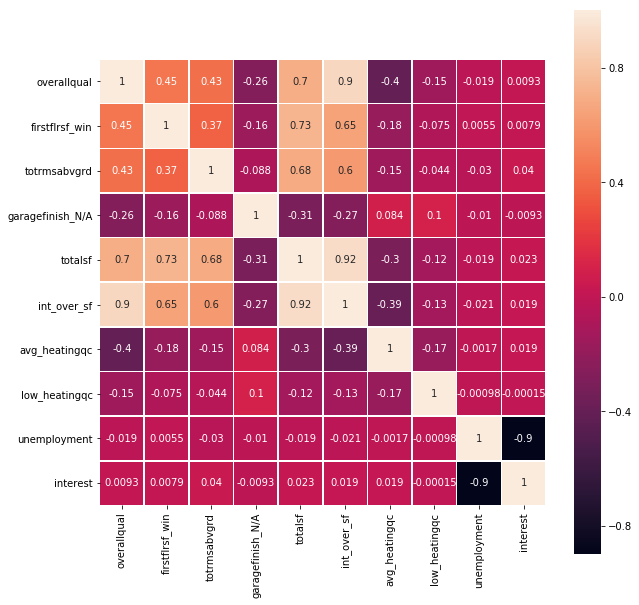

In [933]:
corrmat_houses4 = houses_prices_new[new_model_features].corr()
plt.figure(figsize = (10,10))
sns.heatmap(corrmat_houses4, square = True, annot = True, linewidths = 0.5)

In [934]:
new_features_and_target = ['unemployment', 'interest', 'saleprice_win']
np.abs(houses_prices_new[new_features_and_target].iloc[:,0:].corr().loc[:,"saleprice_win"]).sort_values(ascending=False)

saleprice_win    1.000000
unemployment     0.024132
interest         0.021692
Name: saleprice_win, dtype: float64

From the above correlation matrix heatmap, there is a clear high correlation between the new features ("interest" and "unemployment"). "interest" feature will not be considered in the model since it has a lower correlation with the target variable "saleprice_win". the correlation between these features and the target variable is not encouraging because they are extremely low.

In [935]:
new_model_features.remove('interest')

## Model #4

In [936]:
Y4 = houses_prices_new['saleprice_win']
X4 = houses_prices_new[new_model_features]

In [937]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, Y4, test_size = 0.2, random_state = 465)

print('The number of observations in training set is {}'.format(X4_train.shape[0]))
print('The number of observations in test set is {}'.format(X4_test.shape[0]))

The number of observations in training set is 1167
The number of observations in test set is 292


In [938]:
X4_train = sm.add_constant(X4_train)

lrm4 = sm.OLS(y4_train, X4_train).fit()

lrm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          saleprice_win   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     586.6
Date:                Mon, 09 Sep 2019   Prob (F-statistic):               0.00
Time:                        14:37:22   Log-Likelihood:                -13394.
No. Observations:                1167   AIC:                         2.681e+04
Df Residuals:                    1157   BIC:                         2.686e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -3963.3601   1.25e+04     -0.317      0.752   -2.85e+04    2.06e+04
overallqual       1.211e+04   1999.959      6.057      0.000    8189.741     1.6e+04
firstflrsf_win       0.3580      3.480      0.103      0.918      -6.469       7.185
totrmsabvgrd     -1519.2131    625.981     -2.427      0.015   -2747.399    -291.027
garagefinish_N/A  6240.9551   3465.029      1.801      0.072    -557.489     1.3e+04
totalsf             31.3599      4.473      7.012      0.000      22.585      40.135
int_over_sf          1.3361      0.586      2.279      0.023       0.186       2.486
avg_heatingqc     -1.12e+04   1585.194     -7.066      0.000   -1.43e+04   -8090.154
low_heatingqc    -5497.8719   3897.964     -1.410      0.159   -1.31e+04    2149.999
unemployment      -149.4333    305.078     -0.490      0.624    -748.001     449.134
==============================================================================
Omnibus:                      132.129   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              625.546
Skew:                          -0.417   Prob(JB):                    1.46e-136
Kurtosis:                       6.489   Cond. No.                     3.93e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.93e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Model Evaluation

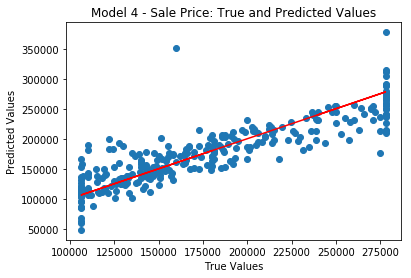

Mean absolute error of the prediction is: 19415.68180151628
Mean squared error of the prediction is: 784191162.8575851
Root mean squared error of the prediction is: 28003.4134143962
Mean absolute percentage error of the prediction is: 11.828161386882023


In [939]:
X4_test = sm.add_constant(X4_test)

y4_preds = lrm4.predict(X4_test)

plt.scatter(y4_test, y4_preds)
plt.plot(y4_test, y4_test, color='red')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Model 4 - Sale Price: True and Predicted Values')
plt.show()

print('Mean absolute error of the prediction is: {}'.format(mean_absolute_error(y4_test, y4_preds)))
print('Mean squared error of the prediction is: {}'.format(mse(y4_test, y4_preds)))
print('Root mean squared error of the prediction is: {}'.format(rmse(y4_test, y4_preds)))
print('Mean absolute percentage error of the prediction is: {}'.format(np.mean(np.abs((y4_test - y4_preds) / y4_test)) * 100))

In [940]:
print(cross_val_score(LinearRegression(), X4, Y4, scoring='r2', cv = 5))

[0.82615171 0.81761083 0.81376031 0.81371012 0.73537566]


It was expected that economic features had an impact on houses prices during the recession, but from the collected data, the relationship between these features ('interest' and 'unemployment') and the houses prices is extremely low as the correlation between each of them and the houses prices is close to zero (0.02). After considering 'unemployment' feature in the linear regression model, no change in terms of R-Square value or model performance. the coefficient of 'unemployment' feature where not statistically significant (p_value = 0.624 > 0.05) which supports our previous findings.